# Data for Good: predicting suicidal behavior likelihood among Reddit users using Deep Learning (Part 3)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*No one is useless in this world who lightens the burdens of another.*  
― **Charles Dickens**

<img src='https://www.discover-norway.no/upload/images/-development/header/desktop/kul_munch/edvard%20munch%20the%20scream%201893_munchmmuseet.jpg'></img>

## Table of contents
1. [Data Preparation](#preparation)  
2. [Model Development: Recurrent Neural Network](#model)  
  2.1. [...](#kmeans)  
  2.2. [...](#hac)  
  2.3. [...](#dbscan)  
3. [Results](#results)  
4. [Discussion](#discussion)  
5. [Conclusion](#conclusion)  
  5.1. [Project Summary](#summary)  
  5.2. [Outcome of the Analysis](#outcome)  
  5.3. [Potential Developments](#developments)

## 1. Data Preparation <a name=preparation></a>

Steps to process the data for modeling:
1. Drop not-relevant features.
2. Remove stopwords from data.
3. Split dataset into training and testing sets.
4. Tokenize the posts.
5. Pad the sequences.

In [1]:
#Import needed libraries
import keras
import pandas as pd
import random
from random import randrange, seed
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS

In [2]:
#Import data (after cleaning and the EDA perfomed in word-cloud environment notebook)
data = pd.read_csv(r'data.csv')
processed_data = data.copy()
processed_data.head()

,User,Post,Label,word_count,Post_nostopwords,class
0,user-0,its not a viable option and youll be leaving y...,Supportive,134,viable option leaving wife behind youd pain be...,0
1,user-1,it can be hard to appreciate the notion that y...,Ideation,2163,appreciate notion meet deeply boyfriend desire...,1
2,user-2,hi so last night i was sitting on the ledge of...,Behavior,470,hi night sitting ledge window contemplating wh...,1
3,user-3,i tried to kill my self once and failed badly ...,Attempt,885,tried kill self failed badly cause moment want...,1
4,user-4,hi nem3030 what sorts of things do you enjoy d...,Ideation,208,hi nem3030 sorts enjoy personally welcome musi...,1


##### 1. Drop not-relevant features.

In [3]:
#Drop not relevant features
processed_data.drop(['User', 'word_count', 'Label', 'Post_nostopwords'], axis=1, inplace=True)
processed_data.tail()

,Post,class
495,its not the end it just feels that way or at l...,0
496,it was a skype call but she ended it and ventr...,0
497,that sounds really weird maybe you were distra...,0
498,dont know there as dumb as it sounds i feel hy...,1
499,gt it gets better trust me ive spent long enou...,1


###### 2. Remove the stop words.

In [4]:
print("First 50 stop words:\n", list(STOPWORDS)[:51])

First 50 stop words:
 ['since', 'but', 'nor', 'we', 'cannot', 'over', "wasn't", "we'll", 'shall', 'own', 'further', 'yourself', "she'll", 'or', 'some', "where's", 'there', 'ought', 'were', "haven't", 'more', 'are', 'otherwise', 'ever', 'why', 'has', 'other', 'above', 'your', 'between', "wouldn't", 'too', 'with', 'itself', "hadn't", "that's", 'a', 'like', "won't", 'yourselves', "i'm", "didn't", 'down', "there's", 'from', "she's", 'how', 'www', 'under', 'this', 'can']


In [5]:
#let's visualize a random post
random.seed(3)
processed_data.loc[randrange(500)]['Post']

'no more ideas i dont agree with live for others kind of advice i think you should live for yourself and your friends and family the world isnt going to be fixed any time soon so stop thinking its all on your shoulders regular exercise and a lack of excessive stress is important to a good life so is a decent job work is now stressful yes its never done im on a long break now its tired hot and humid where i now live so i cant really do anything i cant handle the heat well i want to prepare for my death before i go back to work its not only that the career enabled me to live a certain lifestyle and live in a certain place and not have to worry too much about money and other things why would you like that i dont think there are any other kinds of job i could do in this country it has been 5 years since i lost my job i have tried my best the things i lost in my life i believe them to be extremely fundamental and important things i also lost a life that had little worry and stress now i hav

In [6]:
random.seed(3)
print('Length of the post before removing the stop words:', len(processed_data.loc[randrange(500)]['Post']))

Length of the post before removing the stop words: 2269


In [7]:
#let's remove the stop words
processed_data['Post']=processed_data['Post'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))

In [8]:
random.seed(3)
processed_data.loc[randrange(500)]['Post']

'ideas dont agree live others kind advice think live friends family world isnt going fixed time soon stop thinking shoulders regular exercise lack excessive stress important good life decent job work now stressful yes never done im long break now tired hot humid now live cant really anything cant handle heat well want prepare death go back work career enabled live certain lifestyle live certain place worry much money things dont think kinds job country 5 years lost job tried best things lost life believe extremely fundamental important things lost life little worry stress now job gets worse every day doesnt allow time exercise boiling hot city saps energy horrible bitchy colleagues norm come realize really liked living country kind still jobs will worse live world shitty jobs one best jobs world threw away cant tolerate job isnt good say rest move different job industry city time less hot humid place wont good climate city even ill still lost years life people dont understand suicide a

In [9]:
random.seed(3)
print('Length of the post after removing the stop words:', len(processed_data.loc[randrange(500)]['Post']))

Length of the post after removing the stop words: 1369


###### 3. Split the dataset into training and testing sets.

Let's split the dataset into train and test sets. I use 20% of the dataset (100 observations) as test data, and the stratify parameter to preserve the class imbalance.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(processed_data['Post'], processed_data['class'], test_size=0.2,
                                                    random_state=666, stratify = processed_data['class'])

In [11]:
print('Training dataset shape:', x_train.shape)
print('Testing dataset shape:', x_test.shape)
print('Training label shape:', y_train.shape)
print('Testing label shape:', y_test.shape)

Training dataset shape: (400,)
Testing dataset shape: (100,)
Training label shape: (400,)
Testing label shape: (100,)


###### 3. Tokenize the text.

I am going to tokenize the posts, that is I'll turn each user's posts into a list of individual words and then convert the words into integers, using the Keras Tokenizer class.

In [12]:
#let's create a tokenizer object with a token for out-of-vocabulary words
tokenizer = Tokenizer(oov_token='OOV')

In [13]:
#let's fit the tokenizer on the training set only
tokenizer.fit_on_texts(x_train)

In [14]:
#let's visualize a random post from the training set
random.seed(13)
x_train.reset_index(inplace=False, drop=True)[randrange(400)]

'dont much currently lifeguard bit cash im heading school september pretty much whether something want idea currently never feel anything used make happy years happy minutes guess making things programming art stuff havent able concentrate much anything will plan something lose drive dont follow though building really closest pool 15 25 minute drive guess try going every swam much long didnt much appeal last two seasons competed last years estimated swimming somewhere around 3 million yards year dont really feel going back actually lab animals dont make feel better better shape people used swim 2 4 hours day five days week dont anymore im still physically healthy blood test nothing showed take multivitamin eat fairly well honestly dont know guess something wrong brain functions im really stressed never bee one worry much lately ive wishing way though medication death whatever medicines never worked well anti depressants ive taken done fuck guess friends finding will everyday hard let a

In [15]:
#convert text into lists of integers for the training set
x_train = tokenizer.texts_to_sequences(x_train)

In [16]:
#let's visualize the same post after tokenizing
random.seed(13)
x_train[randrange(400)]

[3,
 27,
 671,
 10748,
 143,
 3200,
 2,
 3495,
 81,
 4670,
 145,
 27,
 391,
 26,
 9,
 245,
 671,
 49,
 8,
 48,
 237,
 25,
 80,
 64,
 80,
 682,
 211,
 206,
 13,
 1967,
 720,
 200,
 156,
 114,
 2404,
 27,
 48,
 6,
 460,
 26,
 372,
 630,
 3,
 730,
 71,
 1272,
 12,
 1737,
 3733,
 763,
 1153,
 1410,
 630,
 211,
 34,
 22,
 98,
 6183,
 27,
 79,
 72,
 27,
 2343,
 160,
 173,
 5691,
 10749,
 160,
 64,
 10750,
 2845,
 453,
 92,
 324,
 1754,
 10751,
 123,
 3,
 12,
 8,
 22,
 58,
 116,
 10752,
 1877,
 3,
 25,
 8,
 19,
 19,
 1337,
 5,
 237,
 2485,
 261,
 481,
 411,
 55,
 961,
 155,
 480,
 3,
 229,
 2,
 41,
 843,
 653,
 1231,
 1158,
 89,
 1495,
 43,
 10753,
 768,
 1273,
 39,
 293,
 3,
 4,
 211,
 26,
 180,
 417,
 7239,
 2,
 12,
 5176,
 49,
 10754,
 16,
 656,
 27,
 943,
 29,
 2254,
 23,
 71,
 346,
 217,
 169,
 3584,
 49,
 471,
 39,
 910,
 1657,
 29,
 642,
 164,
 223,
 211,
 45,
 368,
 6,
 592,
 63,
 83,
 117,
 876,
 31]

In [17]:
#Let's map the intetgers back to words to check integer meaning
random.seed(13)
' '.join(tokenizer.index_word[w] for w in x_train[randrange(400)])

'dont much currently lifeguard bit cash im heading school september pretty much whether something want idea currently never feel anything used make happy years happy minutes guess making things programming art stuff havent able concentrate much anything will plan something lose drive dont follow though building really closest pool 15 25 minute drive guess try going every swam much long didnt much appeal last two seasons competed last years estimated swimming somewhere around 3 million yards year dont really feel going back actually lab animals dont make feel better better shape people used swim 2 4 hours day five days week dont anymore im still physically healthy blood test nothing showed take multivitamin eat fairly well honestly dont know guess something wrong brain functions im really stressed never bee one worry much lately ive wishing way though medication death whatever medicines never worked well anti depressants ive taken done fuck guess friends finding will everyday hard let a

In [18]:
#let's visualize a random post from the test set
random.seed(13)
x_test.reset_index(inplace=False, drop=True)[randrange(100)]

'said mean thing earlier apologize shouldnt let jealousy better especially wanted help people live tennessee im using mostly job boards businesses around refuse speak anybody regarding employment going door door ive local unemployment office multiple times fact response every time tried online job boards try online job boards cant offer help use online job boards thing less happened went universitys employment services office dont know economic area stacks places despite efforts ive looking work past 2 months found one job one job lasted two days job im getting unemployment benefits right now im review past month say nothing fact ive searching work past 4 years ive looking different job first 3 found job actually liked wound getting laid put situation im now basically past experiences lead believe hopeless situation'

In [19]:
#convert text into lists of integers for the testing set
x_test = tokenizer.texts_to_sequences(x_test)

In [20]:
#let's visualize the same post after tokenizing
random.seed(13)
x_test[randrange(100)]

[86,
 196,
 44,
 1610,
 1117,
 381,
 83,
 3658,
 19,
 322,
 171,
 15,
 5,
 68,
 1,
 2,
 810,
 728,
 91,
 4696,
 4900,
 92,
 1928,
 527,
 1215,
 2210,
 2448,
 22,
 1200,
 1200,
 29,
 822,
 1783,
 1622,
 1321,
 149,
 244,
 718,
 98,
 14,
 139,
 483,
 91,
 4696,
 34,
 483,
 91,
 4696,
 33,
 351,
 15,
 234,
 483,
 91,
 4696,
 44,
 263,
 290,
 188,
 8673,
 2448,
 1059,
 1622,
 3,
 4,
 3271,
 640,
 1,
 565,
 839,
 2640,
 29,
 167,
 46,
 233,
 261,
 220,
 197,
 16,
 91,
 16,
 91,
 2392,
 173,
 155,
 91,
 2,
 113,
 1783,
 2920,
 38,
 18,
 2,
 4428,
 233,
 514,
 40,
 89,
 244,
 29,
 1541,
 46,
 233,
 481,
 64,
 29,
 167,
 161,
 91,
 84,
 324,
 197,
 91,
 116,
 878,
 1640,
 113,
 2451,
 147,
 127,
 2,
 18,
 466,
 233,
 558,
 1030,
 109,
 456,
 127]

In [21]:
#Let's map the intetgers back to words to check integer meaning
random.seed(13)
' '.join(tokenizer.index_word[w] for w in x_test[randrange(100)])

'said mean thing earlier apologize shouldnt let jealousy better especially wanted help people live OOV im using mostly job boards businesses around refuse speak anybody regarding employment going door door ive local unemployment office multiple times fact response every time tried online job boards try online job boards cant offer help use online job boards thing less happened went universitys employment services office dont know economic area OOV places despite efforts ive looking work past 2 months found one job one job lasted two days job im getting unemployment benefits right now im review past month say nothing fact ive searching work past 4 years ive looking different job first 3 found job actually liked wound getting laid put situation im now basically past experiences lead believe hopeless situation'

In [22]:
print('The training data contains {} unique words'.format(f'{len(tokenizer.word_index.items()):,}'))

The training data contains 15,754 unique words


###### 5. Pad the sequences.

Let's now create sequences of the same lenght. During the Exploratory Data Analysis we have foud out the 80% of posts have fewer than 2,000 words. Therefore I set the maximum sequence length as 2,000: post longer than 2,000 words will be truncated, whilst posts shorter then 2,000 words will be padded.

posts = pad_sequences(posts, maxlen=2000, padding='post', truncating='post')
#posts[0]

## 2. Model Development <a name= 'model'></a>

In [23]:
#pip install tensorflow-determinism

Note: you may need to restart the kernel to use updated packages.


In natural language processing (NLP), a word embedding is a representation of a word in the form of a vector (of a given dimenion) that encodes the meaning of the word; words that have similar meaning should also be closer in the vector space, that is they have a similar representation.  
When working on a NLP problem, there are 2 options:
1. Train your own word embeddings. In this case, the embeddings are learnt using the dataset for the specific problem that someone is trying to solve.
2. Apply **Transfer Learning** concept, that is using pre-trained word embeddings, that is embeddings learnt on large datasets, saved, and then used for solving other tasks.

For this project, I'll build 3 models, using the Recurrent Neural Network class;  training the models using:
1. Learn my own word emebeddings vs using pre-trained word embeddings 
2. Simple Recurrent Neural Network
3. Gated Recurrent Unit (GRU)
4. Long Short Term Memory (LSTM)

Model hyperparameters:
- embeddeding layer dimensions and train/pretrained
- number of layers before/after the recorrent section of the network
- the state dimension
- RNN initializersL default
- number of neurons in the hidden layer(s)
- activation functions for the hidden layers (sigmoid, tangent, relu, leaky relu)
- learning rate
- bach size (usually 16 or 32)
- number of epochs
- regularization: stochastic or mini-batch (evaluate other regularization techinque only if the model overfits the data)
- optimizers

In [23]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding, GRU
from keras.callbacks import EarlyStopping
from numpy.random import seed
import os
#os.environ['PYTHONHASHSEED']=str(2)
import tensorflow as tf
import matplotlib.pyplot as plt

### 2.3 Using Pre-trained Word Embeddings: Google News Word2Vec model.

In [360]:
#import urllib.request
#urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

In [24]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(r'glove.6B\glove.6B.300d.txt', encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [25]:
# create a weight matrix for words in the training set
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))
hits = 0
misses = 0

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted {} words ({} misses)".format(f'{hits:,}', f'{misses:,}'))

Converted 14,072 words (1,682 misses)


In [27]:
#Pad the sequences
x_train_pad = pad_sequences(x_train, maxlen=100, padding='pre', truncating='pre')
x_test_pad = pad_sequences(x_test, maxlen=100, padding='pre', truncating='pre')

In [64]:
seed(42)
tf.random.set_seed(42)
#Initialize the model
rnn_glove = Sequential()

#I am not using Glove pre-trained embeddings
rnn_glove.add(Embedding(len(tokenizer.word_index.items())+1, output_dim=300, weights=[embedding_matrix], trainable=False))

# Add the RNN layer
rnn_glove.add(SimpleRNN(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                        input_shape=x_train_pad.shape[1:]))

# Add the final output layer
rnn_glove.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
rnn_glove.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
rnn_glove.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 300)         4726500   
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 150)               67650     
                                                                 
 dense_15 (Dense)            (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 67,801
Non-trainable params: 4,726,500
_________________________________________________________________


In [65]:
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, verbose=1, patience=9)
hist=rnn_glove.fit(x_train_pad,y_train,batch_size=16,epochs=20,shuffle=True,validation_data=(x_test_pad, y_test),callbacks=[es])

Epoch 1/20
25/25 [==============================] - 4s 73ms/step - loss: 0.7484 - accuracy: 0.5300 - val_loss: 0.7516 - val_accuracy: 0.5000
Epoch 2/20
25/25 [==============================] - 1s 46ms/step - loss: 0.4578 - accuracy: 0.8300 - val_loss: 0.8610 - val_accuracy: 0.4700
Epoch 3/20
25/25 [==============================] - 1s 48ms/step - loss: 0.2688 - accuracy: 0.9350 - val_loss: 0.8692 - val_accuracy: 0.5100
Epoch 4/20
25/25 [==============================] - 1s 37ms/step - loss: 0.1399 - accuracy: 0.9750 - val_loss: 1.0139 - val_accuracy: 0.5400
Epoch 5/20
25/25 [==============================] - 1s 39ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 1.2222 - val_accuracy: 0.5400
Epoch 6/20
25/25 [==============================] - 1s 39ms/step - loss: 0.0398 - accuracy: 0.9950 - val_loss: 1.4483 - val_accuracy: 0.5200
Epoch 7/20
25/25 [==============================] - 1s 43ms/step - loss: 0.0847 - accuracy: 0.9775 - val_loss: 1.1753 - val_accuracy: 0.4800
Epoch 8/20
25

C:\Users\sebas\AppData\Local\Temp\ipykernel_13196\1232999673.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  accuracy.set_xticklabels(range(0,9))
C:\Users\sebas\AppData\Local\Temp\ipykernel_13196\1232999673.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  loss.set_xticklabels(range(0,9))


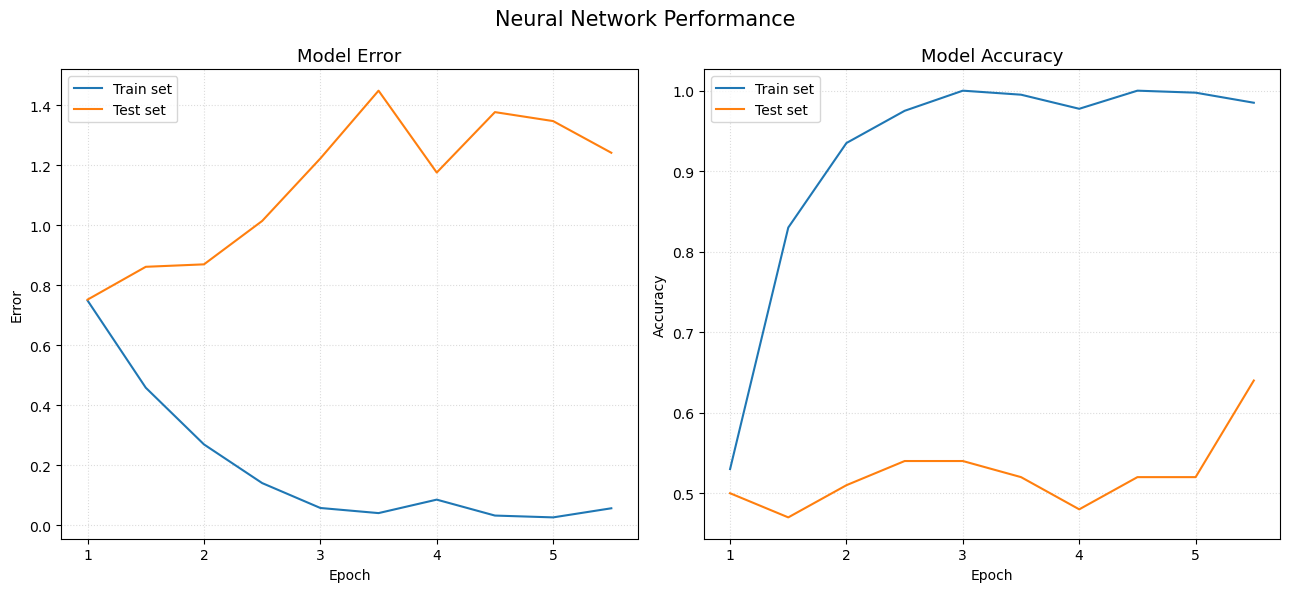

In [66]:
fig = plt.figure(figsize=(13,6))
loss = fig.add_subplot(1,2,1) 
accuracy = fig.add_subplot(1,2,2)

accuracy.plot(hist.history['accuracy'])
accuracy.plot(hist.history['val_accuracy'])
accuracy.set_title('Model Accuracy', fontsize=13)
accuracy.set_ylabel('Accuracy')
accuracy.set_xlabel('Epoch')
accuracy.set_xticklabels(range(0,9))
accuracy.legend(['Train set', 'Test set'], loc='best')
accuracy.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

loss.plot(hist.history['loss'])
loss.plot(hist.history['val_loss'])
loss.set_title('Model Error', fontsize=13)
loss.set_ylabel('Error')
loss.set_xlabel('Epoch')
loss.set_xticklabels(range(0,9))
loss.legend(['Train set', 'Test set'], loc='best')
loss.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

plt.suptitle('Neural Network Performance', fontsize=15)
plt.tight_layout()
plt.show()

---

**Gated Recurrent Unit**

In [ ]:
#Initialize the model
gru_rnn = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 50-dimensional vector.
#I am not using any pre-trained embeddings
gru_rnn.add(Embedding(posts.max()+1, output_dim=300, trainable=True, mask_zero=True))

# Add the RNN layer
gru_rnn.add(GRU(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                recurrent_activation="sigmoid", input_shape=x_train.shape[1:]))

# Add the more dense layers and the final output layer
gru_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
gru_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
gru_rnn.summary()

In [ ]:
gru_rnn.fit(x_train, y_train, batch_size=16, epochs=10, shuffle=True, validation_data=(x_test, y_test))

---

In [ ]:
#Initialize the model
gru_rnn = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 50-dimensional vector.
#I am not using any pre-trained embeddings
gru_rnn.add(Embedding(posts.max()+1, output_dim=300, trainable=True, mask_zero=True))

# Add the RNN layer
gru_rnn.add(GRU(units=150, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',activation='tanh',
                recurrent_activation="sigmoid", input_shape=x_train.shape[1:], dropout=0.25, recurrent_dropout=0.25))

# Add the more dense layers and the final output layer
gru_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
gru_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
gru_rnn.summary()

In [ ]:
gru_rnn.fit(x_train, y_train, batch_size=16, epochs=10, shuffle=True, validation_data=(x_test, y_test))

Model 2: reducing complexity by reducing parameters, and using dropout.

In [ ]:
posts_1000 = pad_sequences(posts, maxlen=1000, padding='post', truncating='post')

In [ ]:
model_data = np.concatenate((posts_1000, np.expand_dims(np.array(processed_data['class']), axis=1)), axis=1)
np.shape(model_data)

Let's count now the total number of words that our dataset contains. This is the size of our entire vocabulary.

In [ ]:
num_words = len(np.unique(posts_1000))
print('After the pre-processing stage, the data contains {} unique words'.format(f'{num_words:,}'))

Let's split the dataset into train and test sets. I use 20% of the dataset (100 observations) as test data, and the stratify parameter to preserve the class imbalance.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(model_data[:,:-1], model_data[:,-1], test_size=0.2, random_state=50,
                                                    stratify = model_data[:,-1])

In [ ]:
print('Training feature dataset shape:', x_train.shape)
print('Testing feature dataset shape:', x_test.shape)

In [ ]:
print('Training class dataset shape:', y_train.shape)
print('Testing class dataset shape:', y_test.shape)

In [ ]:
seed(2)
tensorflow.random.set_seed(2)

#Initialize the model
rnn_2 = Sequential()

# Add the Embedding layer, which maps each input integer (word) to a 50-dimensional vector.
#I am not using any pre-trained embeddings
rnn_2.add(Embedding(posts_1000.max()+1, output_dim=250, trainable=True, mask_zero=True))

# Add the RNN layer
rnn_2.add(SimpleRNN(units=100, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', activation='tanh',
                    input_shape=x_train.shape[1:]))

# Add the more dense layers and the final output layer
rnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
adam = keras.optimizers.Adam(learning_rate=0.001)
rnn_2.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#Let's check the model architecture
rnn_2.summary()

In [ ]:
rnn_2.fit(x_train, y_train, batch_size=16, epochs=10, shuffle=True, validation_data=(x_test, y_test))

In [ ]:
rnn_2.fit(x_train, y_train, batch_size=16, epochs=10, shuffle=True, validation_data=(x_test, y_test))

In [ ]:
rnn_2.fit(x_train, y_train, batch_size=16, epochs=10, shuffle=True, validation_data=(x_test, y_test))

In [ ]:
rnn_2.fit(x_train, y_train, batch_size=16, epochs=5, shuffle=True, validation_data=(x_test, y_test))

In [ ]:
rnn_2.fit(x_train, y_train, batch_size=16, epochs=5, shuffle=True, validation_data=(x_test, y_test))

---

In [ ]:
y_pred_train = rnn_2.predict(x_train)
sum(np.argmax(y_train, axis=1) == np.argmax(y_pred_train, axis=1))

In [ ]:
y_pred = rnn_2.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

In [ ]:
np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 0)[0]],return_counts=True)[1]

In [ ]:
2/22

In [ ]:
#actual class: supportive (0)
i=0
for v in np.unique(y_pred[np.where(np.argmax(y_test, axis=1) == 0)]):
    print(v,
          np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 0)[0]],return_counts=True)[1][i]/
          len(np.where(np.argmax(y_test,axis=1)==0)[0]))
    i+=1

In [ ]:
np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 1)[0]],return_counts=True)

In [ ]:
len(np.where(np.argmax(y_test,axis=1)==1)[0])

In [ ]:
6/20

In [ ]:
#actual class: indicator (1)
i=0
for v in np.unique(y_pred[np.where(np.argmax(y_test, axis=1) == 1)]):
    print(v,
          np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 1)[0]],return_counts=True)[1][i]/
          len(np.where(np.argmax(y_test,axis=1)==1)[0]))
    i+=1

In [ ]:
np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 2)[0]],return_counts=True)

In [ ]:
len(np.where(np.argmax(y_test,axis=1)==2)[0])

In [ ]:
11/34

In [ ]:
#actual class: ideation (2)
i=0
for v in np.unique(y_pred[np.where(np.argmax(y_test, axis=1) == 2)]):
    print(v,
          np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 2)[0]],return_counts=True)[1][i]/
          len(np.where(np.argmax(y_test,axis=1)==2)[0]))
    i+=1

In [ ]:
np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 3)[0]],return_counts=True)

In [ ]:
len(np.where(np.argmax(y_test,axis=1)==3)[0])

In [ ]:
3/15

In [ ]:
#actual class: behavior (3)
i=0
for v in np.unique(y_pred[np.where(np.argmax(y_test, axis=1) == 3)]):
    print(v,
          np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 3)[0]],return_counts=True)[1][i]/
          len(np.where(np.argmax(y_test,axis=1)==3)[0]))
    i+=1

In [ ]:
np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 4)[0]],return_counts=True)

In [ ]:
len(np.where(np.argmax(y_test,axis=1)==4)[0])

In [ ]:
3/9

In [ ]:
#actual class: attempt (4)
i=0
for v in np.unique(y_pred[np.where(np.argmax(y_test, axis=1) == 4)]):
    print(v,
          np.unique(y_pred[np.where(np.argmax(y_test,axis=1) == 4)[0]],return_counts=True)[1][i]/
          len(np.where(np.argmax(y_test,axis=1)==4)[0]))
    i+=1

Extras:
1. can I do cross validation / hyperparameters tuning with deep learnig models: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/#:~:text=By%20setting%20the%20n_jobs%20argument,for%20each%20combination%20of%20parameters.

---

sources for data-preprocessing (NLP):
- https://towardsdatascience.com/recurrent-neural-networks-by-example-in-python-ffd204f99470
- https://medium0.com/@saad.arshad102/sentiment-analysis-text-classification-using-rnn-bi-lstm-recurrent-neural-network-81086dda8472

---

data source: https://www.kaggle.com/datasets/thedevastator/c-ssrs-labeled-suicidality-in-500-anonymized-red
https://zenodo.org/record/2667859#.Y9aqCXZBw2z